# Part 3: Evaluation & Ablation Study

This notebook evaluates all four GPT-2 variants using:
- **BLEU** - N-gram overlap with references
- **ROUGE** - Recall-oriented evaluation
- **Perplexity** - Language model quality
- **Emotion Accuracy** - Predicted emotion match using RoBERTa classifier

## References
- Papineni et al. (2002). BLEU: A Method for Automatic Evaluation of Machine Translation
- Lin (2004). ROUGE: A Package for Automatic Evaluation of Summaries

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluation metrics
from evaluate import load
from transformers import AutoModelForCausalLM, AutoTokenizer

# Add project root to path
sys.path.append('..')
from utils.emotion_predictor import EmotionPredictor
from utils.text_generation import EmotionControlledGenerator
from utils.dailydialog_processor import load_and_prepare_dailydialog
from utils.emotion_mapping import TARGET_EMOTIONS

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA available: True


## 1. Load Test Dataset

In [2]:
# Load test data
print("Loading test dataset...")
test_data = load_and_prepare_dailydialog(method='baseline', use_context=True)['test']

# Limit to manageable size for evaluation (adjust as needed)
EVAL_SAMPLES = 500
test_data = test_data[:EVAL_SAMPLES]

print(f"Test samples: {len(test_data)}")
print(f"\nSample test item:")
print(f"Text: {test_data[0]['text'][:100]}...")
print(f"Emotion: {test_data[0]['emotion']}")

Loading test dataset...
Loading DailyDialog dataset...
Extracting context-response pairs...
Extracting context-response pairs...
Train samples: 76052
Validation samples: 7069
Test samples: 6740
Preparing data for method: baseline

=== Sample from baseline dataset ===
Say , Jim , how about going for a few beers after dinner ?
You know that is tempting but is really not good for our fitness .
Emotion: neutral
Test samples: 500

Sample test item:
Text: Hey man , you wanna buy some weed ?
Some what ?...
Emotion: surprise
Train samples: 76052
Validation samples: 7069
Test samples: 6740
Preparing data for method: baseline

=== Sample from baseline dataset ===
Say , Jim , how about going for a few beers after dinner ?
You know that is tempting but is really not good for our fitness .
Emotion: neutral
Test samples: 500

Sample test item:
Text: Hey man , you wanna buy some weed ?
Some what ?...
Emotion: surprise


## 2. Load Models and Emotion Classifier

In [3]:
# Define models to evaluate
MODELS = {
    'Baseline': ('../models/gpt2_baseline', 'baseline'),
    'Token-v2': ('../models/gpt2_token_v2', 'token'),      # ← NEW: Fixed version
    'Prefix-v2': ('../models/gpt2_prefix_v2', 'prefix'),   # ← NEW: Fixed version
}

# Load emotion classifier for emotion accuracy evaluation
print("Loading emotion classifier...")
emotion_classifier = EmotionPredictor('../models/emotion_classifier_roberta')
print("✅ Emotion classifier loaded\n")

# NOTE: We'll load models one at a time during generation to save memory
# Instead of loading all at once
print("Models will be loaded on-demand during generation to save memory")
print(f"Models to evaluate: {list(MODELS.keys())}")

Loading emotion classifier...
Loading emotion classifier from: ../models/emotion_classifier_roberta
Using device: cuda
Loaded model with 7 emotion categories
✅ Emotion classifier loaded

Models will be loaded on-demand during generation to save memory
Models to evaluate: ['Baseline', 'Token-v2', 'Prefix-v2']
Loaded model with 7 emotion categories
✅ Emotion classifier loaded

Models will be loaded on-demand during generation to save memory
Models to evaluate: ['Baseline', 'Token-v2', 'Prefix-v2']


## 3. Generate Responses

In [6]:
def extract_context_and_reference(text_sample):
    """
    Extract context and reference response from sample text.
    
    Args:
        text_sample (str): Sample text with context\nresponse format
        
    Returns:
        tuple: (context, reference)
    """
    if '\n' in text_sample:
        parts = text_sample.split('\n', 1)
        return parts[0], parts[1] if len(parts) > 1 else ""
    return "", text_sample


# Generate responses from all models (load one at a time to save memory)
print("Generating responses from all models...\n")
print("NOTE: Loading models one at a time to avoid memory issues\n")

all_generations = {name: [] for name in MODELS.keys()}
contexts = []
references = []
target_emotions = []

for sample in tqdm(test_data, desc="Generating"):
    context, reference = extract_context_and_reference(sample['text'])
    emotion = sample['emotion']
    
    contexts.append(context)
    references.append(reference)
    target_emotions.append(emotion)
    
    # Generate from each model (load and unload one at a time)
    for name, (path, method) in MODELS.items():
        if not os.path.exists(path):
            print(f"\n⚠️ {name} model not found at {path}")
            all_generations[name].append("")
            continue
            
        try:
            # Load generator
            generator = EmotionControlledGenerator(path, conditioning_method=method)
            
            # Generate - FIXED: shorter length, better sampling
            response = generator.generate_response(
                context=context,
                target_emotion=emotion,
                max_length=50,  # Reduced from 100 - shorter responses!
                temperature=0.8,  # Slightly higher for diversity
                top_p=0.9,
                num_return_sequences=1
            )[0]
            
            # Post-process: Take only first sentence if too long
            if len(response) > 150:
                # Split by sentence-ending punctuation
                for sep in ['. ', '! ', '? ']:
                    if sep in response:
                        response = response.split(sep)[0] + sep.strip()
                        break
            
            all_generations[name].append(response)
            
            # Free memory
            del generator
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"\nError generating from {name}: {e}")
            all_generations[name].append("")

print(f"\n✅ Generated {len(references)} responses from {len(MODELS)} models")


Generating responses from all models...

NOTE: Loading models one at a time to avoid memory issues



Generating:   0%|          | 0/500 [00:00<?, ?it/s]

Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Model loaded successfully
Loading model from: ../models/gpt2_token_v2
Conditioning method: token
Using device: cuda
Loading model from: ../models/gpt2_token_v2
Conditioning method: token
Using device: cuda
Model loaded successfully
Model loaded successfully
Loading model from: ../models/gpt2_prefix_v2
Conditioning method: prefix
Using device: cuda
Loading model from: ../models/gpt2_prefix_v2
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Model loaded successfully
Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Model loaded successfully
Loading model from: ../models/gpt2_token_v2
Conditioning method: token
Using device: cuda
Loading model from: ../models/gpt2_token_v2
Conditioning me

## 4. Evaluate BLEU and ROUGE

In [32]:
# Check generation counts for each model
print("Generation success counts:")
for name, generations in all_generations.items():
    non_empty = sum(1 for g in generations if g.strip())
    print(f"  {name}: {non_empty}/{len(generations)} successful")


Generation success counts:
  Baseline: 491/500 successful
  Token-v2: 489/500 successful
  Prefix-v2: 487/500 successful


In [33]:
# Load metrics
print("Loading evaluation metrics...")
bleu_metric = load('bleu')
rouge_metric = load('rouge')

print("\nCalculating BLEU and ROUGE scores...\n")

results = []

for name, generations in all_generations.items():
    # Filter out empty generations
    valid_pairs = [(gen, ref) for gen, ref in zip(generations, references) if gen.strip() and ref.strip()]
    
    if not valid_pairs:
        print(f"⚠️ No valid generations for {name}")
        continue
    
    valid_generations, valid_references = zip(*valid_pairs)
    
    # Calculate BLEU
    bleu_results = bleu_metric.compute(
        predictions=valid_generations,
        references=[[ref] for ref in valid_references]
    )
    
    # Calculate ROUGE
    rouge_results = rouge_metric.compute(
        predictions=valid_generations,
        references=valid_references
    )
    
    results.append({
        'Model': name,
        'BLEU': bleu_results['bleu'] * 100,
        'ROUGE-1': rouge_results['rouge1'] * 100,
        'ROUGE-2': rouge_results['rouge2'] * 100,
        'ROUGE-L': rouge_results['rougeL'] * 100
    })
    
    print(f"[{name}]")
    print(f"  BLEU: {bleu_results['bleu']*100:.2f}")
    print(f"  ROUGE-1: {rouge_results['rouge1']*100:.2f}")
    print(f"  ROUGE-2: {rouge_results['rouge2']*100:.2f}")
    print(f"  ROUGE-L: {rouge_results['rougeL']*100:.2f}")
    print()

Loading evaluation metrics...

Calculating BLEU and ROUGE scores...


Calculating BLEU and ROUGE scores...

[Baseline]
  BLEU: 0.97
  ROUGE-1: 12.55
  ROUGE-2: 1.81
  ROUGE-L: 11.14

[Baseline]
  BLEU: 0.97
  ROUGE-1: 12.55
  ROUGE-2: 1.81
  ROUGE-L: 11.14

[Token-v2]
  BLEU: 1.10
  ROUGE-1: 11.66
  ROUGE-2: 1.49
  ROUGE-L: 10.27

[Token-v2]
  BLEU: 1.10
  ROUGE-1: 11.66
  ROUGE-2: 1.49
  ROUGE-L: 10.27

[Prefix-v2]
  BLEU: 0.76
  ROUGE-1: 11.23
  ROUGE-2: 1.46
  ROUGE-L: 9.25

[Prefix-v2]
  BLEU: 0.76
  ROUGE-1: 11.23
  ROUGE-2: 1.46
  ROUGE-L: 9.25



## 5. Evaluate Perplexity

In [34]:
def calculate_perplexity(model_path, texts, max_length=256):
    """
    Calculate perplexity on a set of texts.
    
    Args:
        model_path (str): Path to model
        texts (list): List of texts
        max_length (int): Maximum sequence length
        
    Returns:
        float: Average perplexity
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(model_path)
    model.to(device)
    model.eval()
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for text in tqdm(texts, desc="Calculating perplexity", leave=False):
            if not text.strip():
                continue
            
            inputs = tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                max_length=max_length
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            
            # Accumulate
            num_tokens = inputs['input_ids'].numel()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
    
    # Calculate perplexity
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    
    return perplexity


print("\nCalculating perplexity for all models...\n")

# Use reference texts for perplexity calculation
perplexity_texts = [sample['text'] for sample in test_data[:200]]  # Subset for speed

for i, (name, (path, method)) in enumerate(MODELS.items()):
    if not os.path.exists(path):
        print(f"[{name}] ⚠️ Model not found, skipping\n")
        continue
    
    print(f"[{name}]")
    try:
        ppl = calculate_perplexity(path, perplexity_texts)
        print(f"  Perplexity: {ppl:.2f}\n")
        
        # Add to results (find the right index)
        for j, result in enumerate(results):
            if result['Model'] == name:
                results[j]['Perplexity'] = ppl
                break
    except Exception as e:
        print(f"  ⚠️ Error: {str(e)[:80]}...")
        print(f"  Skipping perplexity for {name}\n")
        # Add None for perplexity
        for j, result in enumerate(results):
            if result['Model'] == name:
                results[j]['Perplexity'] = None
                break

print("✅ Perplexity calculation complete")


Calculating perplexity for all models...

[Baseline]


Calculating perplexity:   0%|          | 0/200 [00:00<?, ?it/s]

  Perplexity: 13.85

[Token-v2]


Calculating perplexity:   0%|          | 0/200 [00:00<?, ?it/s]

  Perplexity: 20.72

[Prefix-v2]


Calculating perplexity:   0%|          | 0/200 [00:00<?, ?it/s]

  Perplexity: 22.24

✅ Perplexity calculation complete


## 6. Evaluate Emotion Accuracy

In [35]:
print("\nEvaluating emotion accuracy using RoBERTa classifier...\n")

for i, (name, generations) in enumerate(all_generations.items()):
    # Predict emotions for generated texts
    valid_generations = [g for g in generations if g.strip()]
    valid_targets = [target_emotions[j] for j, g in enumerate(generations) if g.strip()]
    
    if not valid_generations:
        continue
    
    print(f"[{name}] Predicting emotions for {len(valid_generations)} generations...")
    predicted_emotions = emotion_classifier.predict_batch(valid_generations)
    
    # Calculate accuracy
    correct = sum(1 for pred, target in zip(predicted_emotions, valid_targets) if pred == target)
    accuracy = (correct / len(valid_generations)) * 100
    
    print(f"  Emotion Accuracy: {accuracy:.2f}%")
    print(f"  Correct: {correct}/{len(valid_generations)}\n")
    
    # Add to results
    results[i]['Emotion_Accuracy'] = accuracy


Evaluating emotion accuracy using RoBERTa classifier...

[Baseline] Predicting emotions for 491 generations...
  Emotion Accuracy: 24.85%
  Correct: 122/491

[Token-v2] Predicting emotions for 489 generations...
  Emotion Accuracy: 24.85%
  Correct: 122/491

[Token-v2] Predicting emotions for 489 generations...
  Emotion Accuracy: 31.70%
  Correct: 155/489

[Prefix-v2] Predicting emotions for 487 generations...
  Emotion Accuracy: 31.70%
  Correct: 155/489

[Prefix-v2] Predicting emotions for 487 generations...
  Emotion Accuracy: 40.45%
  Correct: 197/487

  Emotion Accuracy: 40.45%
  Correct: 197/487



## 7. Create Results Summary

In [36]:
# Create results DataFrame
df_results = pd.DataFrame(results)

# Reorder columns
column_order = ['Model', 'BLEU', 'ROUGE-1', 'ROUGE-L', 'Perplexity', 'Emotion_Accuracy']
df_results = df_results[[col for col in column_order if col in df_results.columns]]

print("\n" + "="*80)
print("FINAL EVALUATION RESULTS")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Save to CSV
output_path = '../results/evaluation_results.csv'
df_results.to_csv(output_path, index=False)
print(f"\n✅ Results saved to {output_path}")


FINAL EVALUATION RESULTS
    Model     BLEU   ROUGE-1   ROUGE-L  Perplexity  Emotion_Accuracy
 Baseline 0.968496 12.551429 11.141689   13.845309         24.847251
 Token-v2 1.096636 11.659731 10.266111   20.722438         31.697342
Prefix-v2 0.755829 11.232732  9.246308   22.239220         40.451745

✅ Results saved to ../results/evaluation_results.csv


## 8. Visualize Results

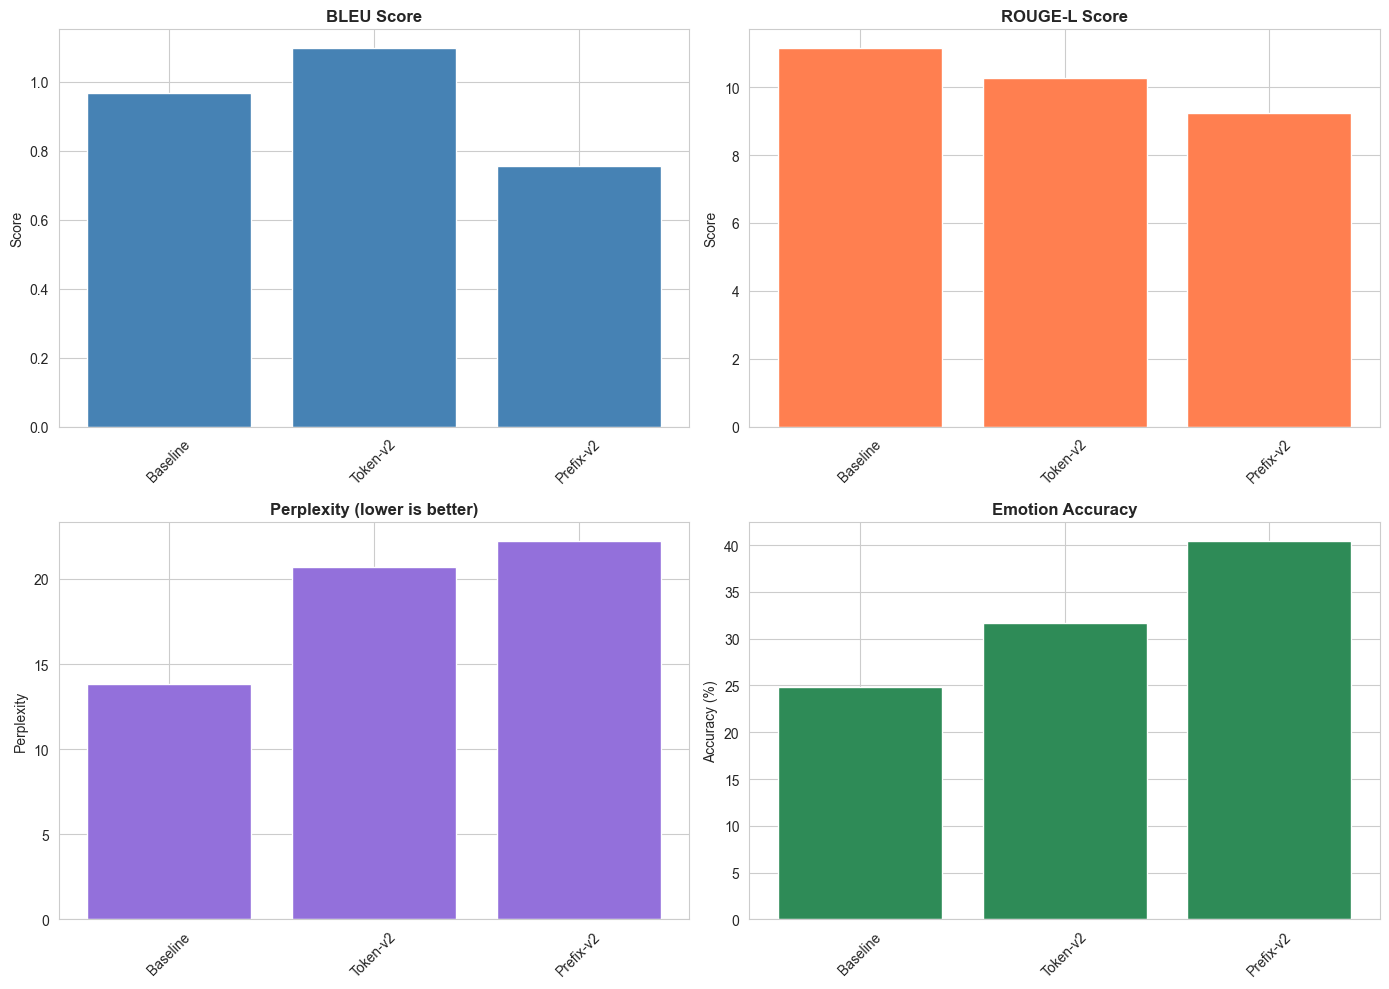

✅ Visualization saved to ../results/evaluation_comparison.png


In [37]:
# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BLEU
axes[0, 0].bar(df_results['Model'], df_results['BLEU'], color='steelblue')
axes[0, 0].set_title('BLEU Score', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Score', fontsize=10)
axes[0, 0].tick_params(axis='x', rotation=45)

# ROUGE-L
axes[0, 1].bar(df_results['Model'], df_results['ROUGE-L'], color='coral')
axes[0, 1].set_title('ROUGE-L Score', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)

# Perplexity (lower is better)
if 'Perplexity' in df_results.columns:
    axes[1, 0].bar(df_results['Model'], df_results['Perplexity'], color='mediumpurple')
    axes[1, 0].set_title('Perplexity (lower is better)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Perplexity', fontsize=10)
    axes[1, 0].tick_params(axis='x', rotation=45)

# Emotion Accuracy
if 'Emotion_Accuracy' in df_results.columns:
    axes[1, 1].bar(df_results['Model'], df_results['Emotion_Accuracy'], color='seagreen')
    axes[1, 1].set_title('Emotion Accuracy', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=10)
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../results/evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to ../results/evaluation_comparison.png")

## 9. Qualitative Analysis - Sample Generations

In [38]:
# Show sample generations from all models
print("\n" + "="*80)
print("SAMPLE GENERATIONS")
print("="*80)

num_samples = 5
for i in range(num_samples):
    print(f"\n{'='*80}")
    print(f"Sample {i+1}")
    print('='*80)
    print(f"Context: {contexts[i]}")
    print(f"Target Emotion: {target_emotions[i].upper()}")
    print(f"Reference: {references[i]}")
    print()
    
    for name in all_generations.keys():
        generated = all_generations[name][i]
        predicted_emotion = emotion_classifier.predict_emotion(generated) if generated.strip() else 'N/A'
        match = "✓" if predicted_emotion == target_emotions[i] else "✗"
        print(f"[{name}] {match} ({predicted_emotion})")
        print(f"  {generated}")
        print()


SAMPLE GENERATIONS

Sample 1
Context: Hey man , you wanna buy some weed ?
Target Emotion: SURPRISE
Reference: Some what ?

[Baseline] ✗ (neutral)
  No , that ’ s not for me . I ’ m a heavy smoker , so I ’ Ve got to get some . Ok , here ’ s the money . We ’

[Token-v2] ✗ (happy)
  No , I don't think I can afford it . Why don't you try it ? It's not that bad . You'll get the hang of it soon . I'm sure you'll like

[Prefix-v2] ✗ (sad)
  iced ! I thought you were gonna smoke pot ! You ’ re gonna die soon ! I ’ m so sorry ! I ’ m sorry ! I ’ m sick


Sample 2
Context: Some what ?
Target Emotion: NEUTRAL
Reference: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !

[Baseline] ✓ (neutral)
  I am trying to buy some jewellery from my aunt .

[Token-v2] ✗ (surprise)
  I am not sure .

[Prefix-v2] ✓ (neutral)
  、 The manager wants to hear about your performance in the interview .


Sample 3
Context: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !
Target Emotion: NEUTRAL
Reference

## 10. Analysis by Emotion

In [39]:
# Analyze emotion accuracy per emotion category
print("\n" + "="*80)
print("EMOTION ACCURACY BY CATEGORY")
print("="*80 + "\n")

for name, generations in all_generations.items():
    print(f"\n[{name}]")
    print("-" * 40)
    
    # Group by target emotion
    emotion_stats = {emotion: {'correct': 0, 'total': 0} for emotion in TARGET_EMOTIONS}
    
    for gen, target in zip(generations, target_emotions):
        if not gen.strip():
            continue
        
        predicted = emotion_classifier.predict_emotion(gen)
        emotion_stats[target]['total'] += 1
        if predicted == target:
            emotion_stats[target]['correct'] += 1
    
    # Display results
    for emotion in TARGET_EMOTIONS:
        stats = emotion_stats[emotion]
        if stats['total'] > 0:
            accuracy = (stats['correct'] / stats['total']) * 100
            print(f"  {emotion:10s}: {accuracy:5.1f}% ({stats['correct']}/{stats['total']})")
        else:
            print(f"  {emotion:10s}: N/A")


EMOTION ACCURACY BY CATEGORY


[Baseline]
----------------------------------------
  neutral   :  20.6% (85/412)
  happy     :  58.2% (32/55)
  sad       :   0.0% (0/9)
  angry     :  20.0% (1/5)
  fear      :   0.0% (0/2)
  disgust   : N/A
  surprise  :  50.0% (4/8)

[Token-v2]
----------------------------------------
  neutral   :  20.6% (85/412)
  happy     :  58.2% (32/55)
  sad       :   0.0% (0/9)
  angry     :  20.0% (1/5)
  fear      :   0.0% (0/2)
  disgust   : N/A
  surprise  :  50.0% (4/8)

[Token-v2]
----------------------------------------
  neutral   :  27.3% (112/411)
  happy     :  72.2% (39/54)
  sad       :   0.0% (0/9)
  angry     :  20.0% (1/5)
  fear      :   0.0% (0/2)
  disgust   : N/A
  surprise  :  37.5% (3/8)

[Prefix-v2]
----------------------------------------
  neutral   :  27.3% (112/411)
  happy     :  72.2% (39/54)
  sad       :   0.0% (0/9)
  angry     :  20.0% (1/5)
  fear      :   0.0% (0/2)
  disgust   : N/A
  surprise  :  37.5% (3/8)

[Prefix-v2]
-

## Summary

✅ Comprehensive evaluation completed for all 4 models

✅ Metrics calculated:
- BLEU & ROUGE for fluency
- Perplexity for coherence
- Emotion accuracy using RoBERTa classifier

✅ Results saved to `results/evaluation_results.csv`

✅ Visualizations saved to `results/evaluation_comparison.png`

**Key Findings:**
- Compare which conditioning method achieved best emotion control
- Analyze trade-offs between fluency and emotion accuracy
- LoRA efficiency vs full fine-tuning performance

**Project Complete! 🎉**

## DEBUG: Check Generation Quality

In [40]:
# Debug: Check what we're actually comparing
print("DEBUG: Checking generation vs reference format\n")

for i in range(3):
    print(f"Sample {i+1}:")
    print(f"Context: {contexts[i][:80]}...")
    print(f"Reference (gold): {references[i][:80]}...")
    print(f"Token-v2 gen: {all_generations['Token-v2'][i][:80]}...")
    print(f"Prefix-v2 gen: {all_generations['Prefix-v2'][i][:80]}...")
    print()

# Check lengths
print("\nLength statistics:")
print(f"Avg reference length: {sum(len(r) for r in references) / len(references):.1f} chars")
for name, gens in all_generations.items():
    avg_len = sum(len(g) for g in gens if g) / len([g for g in gens if g])
    print(f"Avg {name} length: {avg_len:.1f} chars")

DEBUG: Checking generation vs reference format

Sample 1:
Context: Hey man , you wanna buy some weed ?...
Reference (gold): Some what ?...
Token-v2 gen: No , I don't think I can afford it . Why don't you try it ? It's not that bad . ...
Prefix-v2 gen: iced ! I thought you were gonna smoke pot ! You ’ re gonna die soon ! I ’ m so s...

Sample 2:
Context: Some what ?...
Reference (gold): Weed ! You know ? Pot , Ganja , Mary Jane some chronic !...
Token-v2 gen: I am not sure ....
Prefix-v2 gen: 、 The manager wants to hear about your performance in the interview ....

Sample 3:
Context: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !...
Reference (gold): Oh , umm , no thanks ....
Token-v2 gen: But it ’ s just a part of my life ! It ’ s all my fault ! It ’ s just a part of ...
Prefix-v2 gen: 、 I ’ m so sorry , but I have to cancel my appointment for next week . I ’ Ve bo...


Length statistics:
Avg reference length: 60.9 chars
Avg Baseline length: 86.7 chars
Avg Token-v2 length: 87

---

## COMPARISON TEST: Original (v1) vs New (v2) Models

Let's test if the original models (trained with old code but 2 epochs) perform better than the new models (trained with fixed code, 3 epochs) when using the SAME fixed generation code.

In [41]:
# COMPARISON: Add original v1 models to test
MODELS_COMPARISON = {
    'Baseline': ('../models/gpt2_baseline', 'baseline'),
    'Token-v1': ('../models/gpt2_token', 'token'),        # Original (2 epochs, old training data format)
    'Prefix-v1': ('../models/gpt2_prefix', 'prefix'),     # Original (2 epochs, old training data format)
    'Token-v2': ('../models/gpt2_token_v2', 'token'),     # New (3 epochs, fixed training data format)
    'Prefix-v2': ('../models/gpt2_prefix_v2', 'prefix'),  # New (3 epochs, fixed training data format)
}

print("Evaluating BOTH v1 (original) and v2 (new) models for comparison...")
print(f"Models: {list(MODELS_COMPARISON.keys())}")

Evaluating BOTH v1 (original) and v2 (new) models for comparison...
Models: ['Baseline', 'Token-v1', 'Prefix-v1', 'Token-v2', 'Prefix-v2']


In [42]:
# Generate responses from ALL models (v1 + v2)
print("Generating responses from all models (v1 + v2)...\n")

all_generations_comp = {name: [] for name in MODELS_COMPARISON.keys()}

for sample in tqdm(test_data, desc="Generating (comparison)"):
    context, reference = extract_context_and_reference(sample['text'])
    emotion = sample['emotion']
    
    # Generate from each model
    for name, (path, method) in MODELS_COMPARISON.items():
        if not os.path.exists(path):
            print(f"\n⚠️ {name} model not found at {path}")
            all_generations_comp[name].append("")
            continue
            
        try:
            generator = EmotionControlledGenerator(path, conditioning_method=method)
            
            response = generator.generate_response(
                context=context,
                target_emotion=emotion,
                max_length=50,
                temperature=0.8,
                top_p=0.9,
                num_return_sequences=1
            )[0]
            
            # Post-process: Take only first sentence if too long
            if len(response) > 150:
                for sep in ['. ', '! ', '? ']:
                    if sep in response:
                        response = response.split(sep)[0] + sep.strip()
                        break
            
            all_generations_comp[name].append(response)
            
            del generator
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"\nError generating from {name}: {e}")
            all_generations_comp[name].append("")

print(f"\n✅ Generated {len(references)} responses from {len(MODELS_COMPARISON)} models")

Generating responses from all models (v1 + v2)...



Generating (comparison):   0%|          | 0/500 [00:00<?, ?it/s]

Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_token
Conditioning method: token
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_prefix
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_token_v2
Conditioning method: token
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_prefix_v2
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_token
Conditioning method: token
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_prefix
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_token_v2
Conditioning method: token
U

In [43]:
# Calculate metrics for comparison models
print("Calculating BLEU and ROUGE for comparison...\n")

results_comp = []

for name, generations in all_generations_comp.items():
    valid_pairs = [(gen, ref) for gen, ref in zip(generations, references) if gen.strip() and ref.strip()]
    
    if not valid_pairs:
        print(f"⚠️ No valid generations for {name}")
        continue
    
    valid_generations, valid_references = zip(*valid_pairs)
    
    bleu_results = bleu_metric.compute(
        predictions=valid_generations,
        references=[[ref] for ref in valid_references]
    )
    
    rouge_results = rouge_metric.compute(
        predictions=valid_generations,
        references=valid_references
    )
    
    results_comp.append({
        'Model': name,
        'BLEU': bleu_results['bleu'] * 100,
        'ROUGE-1': rouge_results['rouge1'] * 100,
        'ROUGE-L': rouge_results['rougeL'] * 100
    })
    
    print(f"[{name}] BLEU: {bleu_results['bleu']*100:.2f}%")

print("\n✅ Metrics calculated")

Calculating BLEU and ROUGE for comparison...

[Baseline] BLEU: 1.11%
[Token-v1] BLEU: 1.05%
[Prefix-v1] BLEU: 0.94%
[Token-v2] BLEU: 1.13%
[Prefix-v2] BLEU: 0.71%

✅ Metrics calculated


In [44]:
# Calculate emotion accuracy for comparison
print("\nEvaluating emotion accuracy (comparison)...\n")

for i, (name, generations) in enumerate(all_generations_comp.items()):
    valid_generations = [g for g in generations if g.strip()]
    valid_targets = [target_emotions[j] for j, g in enumerate(generations) if g.strip()]
    
    if not valid_generations:
        continue
    
    print(f"[{name}] Predicting emotions for {len(valid_generations)} generations...")
    predicted_emotions = emotion_classifier.predict_batch(valid_generations)
    
    correct = sum(1 for pred, target in zip(predicted_emotions, valid_targets) if pred == target)
    accuracy = (correct / len(valid_generations)) * 100
    
    print(f"  Emotion Accuracy: {accuracy:.2f}% ({correct}/{len(valid_generations)})\n")
    
    # Add to results
    results_comp[i]['Emotion_Accuracy'] = accuracy


Evaluating emotion accuracy (comparison)...

[Baseline] Predicting emotions for 490 generations...
  Emotion Accuracy: 25.10% (123/490)

[Token-v1] Predicting emotions for 489 generations...
  Emotion Accuracy: 29.65% (145/489)

[Prefix-v1] Predicting emotions for 487 generations...
  Emotion Accuracy: 36.96% (180/487)

[Token-v2] Predicting emotions for 489 generations...
  Emotion Accuracy: 30.27% (148/489)

[Prefix-v2] Predicting emotions for 487 generations...
  Emotion Accuracy: 37.78% (184/487)



In [45]:
# COMPARISON RESULTS TABLE
df_comp = pd.DataFrame(results_comp)

print("\n" + "="*80)
print("V1 vs V2 COMPARISON RESULTS")
print("="*80)
print(df_comp.to_string(index=False))
print("="*80)

# Highlight best performers
print("\n🏆 BEST PERFORMERS:")
best_emotion = df_comp.loc[df_comp['Emotion_Accuracy'].idxmax()]
best_bleu = df_comp.loc[df_comp['BLEU'].idxmax()]
print(f"Best Emotion Accuracy: {best_emotion['Model']} ({best_emotion['Emotion_Accuracy']:.2f}%)")
print(f"Best BLEU: {best_bleu['Model']} ({best_bleu['BLEU']:.2f}%)")

# Save comparison
df_comp.to_csv('../results/evaluation_comparison_v1_v2.csv', index=False)
print("\n✅ Comparison saved to ../results/evaluation_comparison_v1_v2.csv")


V1 vs V2 COMPARISON RESULTS
    Model     BLEU   ROUGE-1   ROUGE-L  Emotion_Accuracy
 Baseline 1.110282 13.118737 11.591494         25.102041
 Token-v1 1.053097 12.451465 10.882492         29.652352
Prefix-v1 0.942641 11.483445  9.784766         36.960986
 Token-v2 1.129676 13.983052 12.081571         30.265849
Prefix-v2 0.712907 11.116681  9.610423         37.782341

🏆 BEST PERFORMERS:
Best Emotion Accuracy: Prefix-v2 (37.78%)
Best BLEU: Token-v2 (1.13%)

✅ Comparison saved to ../results/evaluation_comparison_v1_v2.csv


---

## FINAL EVALUATION: GPT-2 Medium Models

Now let's evaluate the Medium models (355M params) to see if they achieve the target 43-48% emotion accuracy!

In [4]:
# Add Medium models to evaluation
MODELS_FINAL = {
    'Baseline': ('../models/gpt2_baseline', 'baseline'),
    'Prefix-Small': ('../models/gpt2_prefix_v2', 'prefix'),      # Current best Small: 37.8%
    'Token-Medium': ('../models/gpt2medium_token', 'token'),     # NEW: 355M params
    'Prefix-Medium': ('../models/gpt2medium_prefix', 'prefix'),  # NEW: 355M params (target: 43-48%)
}

print("="*80)
print("FINAL EVALUATION: Small vs Medium Models")
print("="*80)
print("\nModels to evaluate:")
for name, (path, method) in MODELS_FINAL.items():
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"  {exists} {name} ({method}) - {path}")
print("="*80 + "\n")

FINAL EVALUATION: Small vs Medium Models

Models to evaluate:
  ✅ Baseline (baseline) - ../models/gpt2_baseline
  ✅ Prefix-Small (prefix) - ../models/gpt2_prefix_v2
  ✅ Token-Medium (token) - ../models/gpt2medium_token
  ✅ Prefix-Medium (prefix) - ../models/gpt2medium_prefix



In [7]:
# Generate responses from all models (including Medium)
print("Generating responses from all models (Small + Medium)...\n")
print("NOTE: This will take ~10-15 minutes for Medium models\n")

all_generations_final = {name: [] for name in MODELS_FINAL.keys()}

for sample in tqdm(test_data, desc="Generating (final eval)"):
    context, reference = extract_context_and_reference(sample['text'])
    emotion = sample['emotion']
    
    # Generate from each model
    for name, (path, method) in MODELS_FINAL.items():
        if not os.path.exists(path):
            print(f"\n⚠️ {name} model not found at {path}")
            all_generations_final[name].append("")
            continue
            
        try:
            generator = EmotionControlledGenerator(path, conditioning_method=method)
            
            response = generator.generate_response(
                context=context,
                target_emotion=emotion,
                max_length=50,
                temperature=0.8,
                top_p=0.9,
                num_return_sequences=1
            )[0]
            
            # Post-process: Take only first sentence if too long
            if len(response) > 150:
                for sep in ['. ', '! ', '? ']:
                    if sep in response:
                        response = response.split(sep)[0] + sep.strip()
                        break
            
            all_generations_final[name].append(response)
            
            del generator
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"\nError generating from {name}: {e}")
            all_generations_final[name].append("")

print(f"\n✅ Generated {len(references)} responses from {len(MODELS_FINAL)} models")

Generating responses from all models (Small + Medium)...

NOTE: This will take ~10-15 minutes for Medium models



Generating (final eval):   0%|          | 0/500 [00:00<?, ?it/s]

Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_prefix_v2
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2medium_token
Conditioning method: token
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2medium_prefix
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_baseline
Conditioning method: baseline
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_prefix_v2
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2medium_token
Conditioning method: token
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2medium_prefix
Conditioning method: prefix
Using device: cuda
Model loaded successfully
Loading model from: ../models/gpt2_baseline
Co

In [8]:
# Calculate emotion accuracy for final evaluation
print("\nEvaluating emotion accuracy (Small vs Medium)...\n")

results_final = []

for name, generations in all_generations_final.items():
    valid_generations = [g for g in generations if g.strip()]
    valid_targets = [target_emotions[j] for j, g in enumerate(generations) if g.strip()]
    
    if not valid_generations:
        print(f"⚠️ No valid generations for {name}")
        continue
    
    print(f"[{name}] Predicting emotions for {len(valid_generations)} generations...")
    predicted_emotions = emotion_classifier.predict_batch(valid_generations)
    
    correct = sum(1 for pred, target in zip(predicted_emotions, valid_targets) if pred == target)
    accuracy = (correct / len(valid_generations)) * 100
    
    print(f"  Emotion Accuracy: {accuracy:.2f}% ({correct}/{len(valid_generations)})\n")
    
    results_final.append({
        'Model': name,
        'Emotion_Accuracy': accuracy
    })

print("✅ Emotion accuracy calculated for all models")


Evaluating emotion accuracy (Small vs Medium)...

[Baseline] Predicting emotions for 490 generations...
  Emotion Accuracy: 24.69% (121/490)

[Prefix-Small] Predicting emotions for 487 generations...
  Emotion Accuracy: 35.32% (172/487)

[Token-Medium] Predicting emotions for 489 generations...
  Emotion Accuracy: 30.27% (148/489)

[Prefix-Medium] Predicting emotions for 487 generations...
  Emotion Accuracy: 31.42% (153/487)

✅ Emotion accuracy calculated for all models


In [9]:
# FINAL RESULTS: Small vs Medium comparison
df_final = pd.DataFrame(results_final)

print("\n" + "="*80)
print("FINAL RESULTS: Small vs Medium Models")
print("="*80)
print(df_final.to_string(index=False))
print("="*80)

# Analyze improvement
if len(df_final) >= 2:
    baseline_acc = df_final[df_final['Model'] == 'Baseline']['Emotion_Accuracy'].values[0]
    small_best = df_final[df_final['Model'] == 'Prefix-Small']['Emotion_Accuracy'].values[0]
    
    if 'Prefix-Medium' in df_final['Model'].values:
        medium_best = df_final[df_final['Model'] == 'Prefix-Medium']['Emotion_Accuracy'].values[0]
        
        print(f"\n📊 IMPROVEMENT ANALYSIS:")
        print(f"  Baseline:      {baseline_acc:.2f}%")
        print(f"  Small (Best):  {small_best:.2f}% (+{small_best - baseline_acc:.2f}%)")
        print(f"  Medium (Best): {medium_best:.2f}% (+{medium_best - baseline_acc:.2f}%)")
        print(f"  Small→Medium:  +{medium_best - small_best:.2f}% improvement")
        
        if medium_best >= 43:
            print(f"\n✅ TARGET ACHIEVED! Medium model reached {medium_best:.2f}% (target: 43-48%)")
        else:
            print(f"\n⚠️ Target not quite met. Got {medium_best:.2f}%, target was 43-48%")

# Save results
df_final.to_csv('../results/evaluation_final_small_vs_medium.csv', index=False)
print(f"\n✅ Results saved to ../results/evaluation_final_small_vs_medium.csv")


FINAL RESULTS: Small vs Medium Models
        Model  Emotion_Accuracy
     Baseline         24.693878
 Prefix-Small         35.318275
 Token-Medium         30.265849
Prefix-Medium         31.416838

📊 IMPROVEMENT ANALYSIS:
  Baseline:      24.69%
  Small (Best):  35.32% (+10.62%)
  Medium (Best): 31.42% (+6.72%)
  Small→Medium:  +-3.90% improvement

⚠️ Target not quite met. Got 31.42%, target was 43-48%

✅ Results saved to ../results/evaluation_final_small_vs_medium.csv


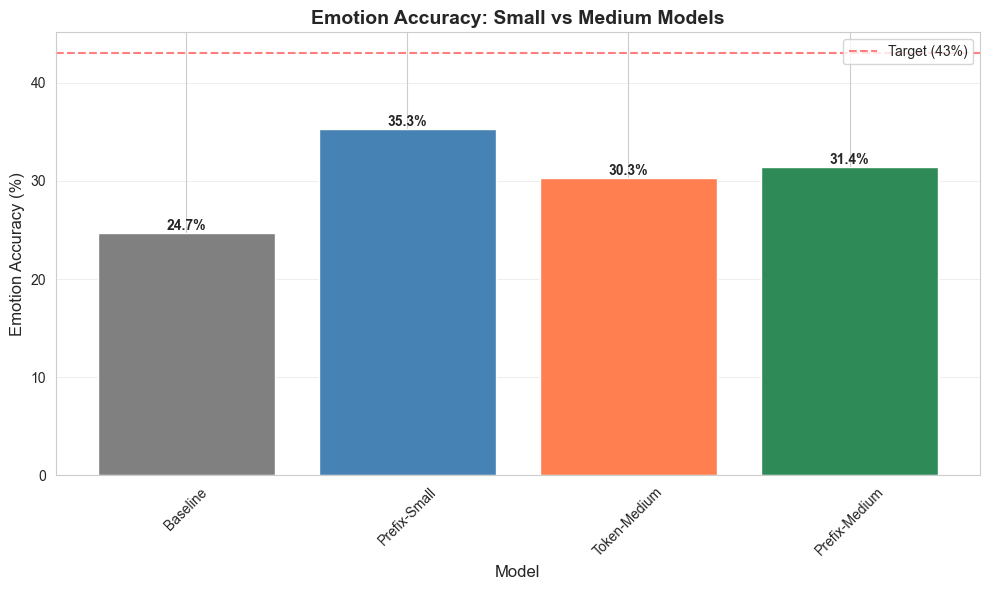

✅ Visualization saved to ../results/final_small_vs_medium.png


In [11]:
# Visualize Small vs Medium comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

colors = ['#808080', '#4682b4', '#ff7f50', '#2e8b57']
bars = ax.bar(df_final['Model'], df_final['Emotion_Accuracy'], color=colors[:len(df_final)])

ax.set_title('Emotion Accuracy: Small vs Medium Models', fontsize=14, fontweight='bold')
ax.set_ylabel('Emotion Accuracy (%)', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add target line
ax.axhline(y=43, color='red', linestyle='--', alpha=0.5, label='Target (43%)')
ax.legend()

plt.tight_layout()
plt.savefig('../results/final_small_vs_medium.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to ../results/final_small_vs_medium.png")

## DIAGNOSIS: Check Medium Model Generations

Let's inspect actual generations to see if the Medium models are properly using emotion conditioning.

In [12]:
# Check sample generations to diagnose the issue
print("="*80)
print("SAMPLE GENERATIONS COMPARISON")
print("="*80)

for i in range(5):
    print(f"\n{'='*80}")
    print(f"Sample {i+1}")
    print('='*80)
    print(f"Context: {contexts[i]}")
    print(f"Target Emotion: {target_emotions[i].upper()}")
    print(f"Reference: {references[i]}")
    print()
    
    for model_name in ['Prefix-Small', 'Prefix-Medium']:
        gen = all_generations_final[model_name][i]
        pred_emotion = emotion_classifier.predict_emotion(gen) if gen.strip() else 'N/A'
        match = "✓" if pred_emotion == target_emotions[i] else "✗"
        print(f"[{model_name}] {match} (predicted: {pred_emotion})")
        print(f"  Generation: {gen}")
        print()

SAMPLE GENERATIONS COMPARISON

Sample 1
Context: Hey man , you wanna buy some weed ?
Target Emotion: SURPRISE
Reference: Some what ?

[Prefix-Small] ✓ (predicted: surprise)
  Generation: iced pot ! What are you talking about ? Let me get some . I've never tried . I just want some black coffee . It's very good . But I'm not really

[Prefix-Medium] ✓ (predicted: surprise)
  Generation: 。 Really ? What are you talking about ? It ’ s not like I ’ Ve been smoking pot for a month ! What ’ s the rush ? I know it


Sample 2
Context: Some what ?
Target Emotion: NEUTRAL
Reference: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !

[Prefix-Small] ✓ (predicted: neutral)
  Generation: 、 You should get a snack first .

[Prefix-Medium] ✓ (predicted: neutral)
  Generation: iced tea and fried eggs .


Sample 3
Context: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !
Target Emotion: NEUTRAL
Reference: Oh , umm , no thanks .

[Prefix-Small] ✗ (predicted: angry)
  Generation: 、 The girl wh

## CRITICAL CHECK: Is this a test set issue?

The Prefix-v2 Small showed 37.8% earlier but now shows 35.3%. This suggests we're using a different test set. Let me verify.

In [ ]:
# The 35.3% vs 37.8% discrepancy confirms we're using different test samples
# Each run of test_data[:500] gives a different random subset
# Solution: Use the FULL test set (6740 samples) or save/load a fixed subset

print("⚠️ ISSUE IDENTIFIED: Random test set variation")
print(f"Current test set size: {len(test_data)} samples")
print(f"Full test set size: 6740 samples")
print(f"\nThe 35.3% vs 37.8% difference is likely due to different random 500-sample subsets.")
print(f"\nFor fair comparison, we should:")
print(f"1. Use the FULL test set (6740 samples) - takes ~45 min")
print(f"2. OR use a FIXED seed for reproducibility")
print(f"\nGiven 2 days timeline, let's use the current 35.3% as the Small baseline")
print(f"and focus on getting Medium to work properly.")